In [169]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *
from  scipy import stats
from sklearn.model_selection import cross_val_score
from category_encoders import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
import math
import pickle
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')


In [170]:
encoder = TargetEncoder()
weatheDf = pd.read_csv("weather.csv")
weatheDf["encodedlocation"] = encoder.fit_transform(weatheDf['location'], weatheDf['rain'])
weatheDf.time_stamp = pd.to_datetime(weatheDf.time_stamp,unit='s')


In [171]:
#weatheDf.month = weatheDf.time_stamp.dt.month
weatheDf['month'] = weatheDf.time_stamp.dt.month
weatheDf.time_stamp = weatheDf.time_stamp.dt.hour
weatheDf = weatheDf.rename(
    columns={
        'time_stamp': 'hour'
    }
)
weatheDf.loc[(weatheDf.hour >= 6) & (
    weatheDf.hour < 12), 'time_of_day'] = 'Morning'
weatheDf.loc[(weatheDf.hour >= 12) & (weatheDf.hour < 15),
             'time_of_day'] = 'Afternoon'
weatheDf.loc[(weatheDf.hour >= 15) & (
    weatheDf.hour < 18), 'time_of_day'] = 'Evening'
weatheDf.loc[(weatheDf.hour >= 18) | (
    weatheDf.hour < 6), 'time_of_day'] = 'Night'
weatheDf = weatheDf.drop(['hour'], axis=1)
#turn month into categorical variable season
weatheDf.loc[(weatheDf.month >= 1) & (weatheDf.month < 4), 'season'] = 'Spring'
weatheDf.loc[(weatheDf.month >= 4) & (weatheDf.month < 7), 'season'] = 'Summer'
weatheDf.loc[(weatheDf.month >= 7) & (weatheDf.month < 10), 'season'] = 'Fall'
weatheDf.loc[(weatheDf.month >= 10) & (
    weatheDf.month < 13), 'season'] = 'Winter'
weatheDf = weatheDf.drop(['month'], axis=1)


In [172]:
scaler = MinMaxScaler()
scaler.fit(weatheDf.drop(['rain', 'location', 'time_of_day','season'], axis=1))
#wweatheDf = pd.DataFrame(scaler.transform(weatheDf.drop('rain',axis=1)), columns= weatheDf.drop('rain',axis=1).columns)
weatheDf1 =weatheDf.copy()
weatheDf.dropna(axis=0,inplace=True)
X = weatheDf.drop(['rain', 'location', 'time_of_day', 'season'], axis=1)
y = weatheDf.rain
x_pred = weatheDf1.drop(['rain', 'location', 'time_of_day','season'],axis=1)

#### Train the model to predict the missing values of rain feature

In [173]:
model = linear_model.LinearRegression()
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X)
x_pred_poly = poly_features.fit_transform(x_pred)
model.fit(X_train_poly, y)
y_train_predicted = model.predict(x_pred_poly)



In [174]:
weatheDf1.rain = y_train_predicted


In [175]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.8,frac_test=0.2,
                                         random_state=None):
    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

 

    assert len(df_input) == len(df_train) + len(df_temp)

    return df_train, df_temp

## working on the Main Dataset

In [176]:

top_feature = list()


In [177]:
def test_sample(sampleData,model):
    sampleData.drop(['product_id'], axis=1, inplace=True)
    sampleData.drop(['id'], axis=1, inplace=True)
    sampleData = sampleData[top_feature]
    for col in sampleData.select_dtypes(include='O').columns:
        encoder = pickle.load(open(f'{col}.pkl', 'rb'))
        sampleData[col] = encoder.transform(sampleData[col])
    y_tru = sampleData['RideCategory']
    sampleData.drop(['RideCategory'], axis=1, inplace=True)
    scaler = pickle.load(open('scaler.pkl', 'rb'))
    scaler.fit(sampleData)
    sampleData = pd.DataFrame(scaler.transform(sampleData))
    clrf = pickle.load(open(model, 'rb'))
    sample_pred = clrf.predict(sampleData)
    print(f'{model} acc', metrics.accuracy_score(y_tru, sample_pred) * 100.0)
    #print sample data and predicted data
    print(sample_pred[1:10])
    print(y_tru[1:10])
        
    
    

In [178]:
weatherData = weatheDf1.drop('encodedlocation', axis=1)
taxiRidersData = pd.read_csv("taxi-rides-classification.csv")
taxiRidersData.time_stamp = pd.to_datetime(
    taxiRidersData.time_stamp, unit="ms")
#taxiRidersData.month =taxiRidersData.time_stamp.dt.month
taxiRidersData['month'] = taxiRidersData.time_stamp.dt.month
print(taxiRidersData['month'].unique())
taxiRidersData.time_stamp = taxiRidersData.time_stamp.dt.hour
taxiRidersData = taxiRidersData.rename(
    columns={
        'time_stamp': 'hour'
    }
)
taxiRidersData = taxiRidersData.drop(['month'], axis=1)
#turn hours into categorical variable time_of_day
taxiRidersData.loc[(taxiRidersData.hour >= 0) & (
    taxiRidersData.hour < 6), 'time_of_day'] = 'Night'
taxiRidersData.loc[(taxiRidersData.hour >= 6) & (
    taxiRidersData.hour < 12), 'time_of_day'] = 'Morning'
taxiRidersData.loc[(taxiRidersData.hour >= 12) & (
    taxiRidersData.hour < 18), 'time_of_day'] = 'Afternoon'
taxiRidersData.loc[(taxiRidersData.hour >= 18) & (
    taxiRidersData.hour < 24), 'time_of_day'] = 'Evening'
taxiRidersData = taxiRidersData.drop(['hour'], axis=1)


[12 11]


In [179]:
taxiRidersData.dropna(axis=0, inplace=True)
avgWeather = weatherData.groupby(["location"]).mean().reset_index(drop=False)
print(taxiRidersData.columns)
sourceWeather = avgWeather.rename(
    columns={
        'location': 'source',
        'rain': 'source_rain',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

destinationWeather = avgWeather.rename(
    columns={
        'location': 'destination',
        'rain': 'destination_rain',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'

    }
)


Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'id', 'product_id', 'name', 'RideCategory', 'time_of_day'],
      dtype='object')


In [180]:
sourceWeather.columns

Index(['source', 'source_temp', 'source_clouds', 'source_pressure',
       'source_rain', 'source_humidity', 'source_wind'],
      dtype='object')

In [181]:
data = taxiRidersData.merge(sourceWeather, on=['source'])\
    .merge(destinationWeather, on=["destination"])
print(data.columns)


Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'id', 'product_id', 'name', 'RideCategory', 'time_of_day',
       'source_temp', 'source_clouds', 'source_pressure', 'source_rain',
       'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind'],
      dtype='object')


In [182]:
print(data.columns)


Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'id', 'product_id', 'name', 'RideCategory', 'time_of_day',
       'source_temp', 'source_clouds', 'source_pressure', 'source_rain',
       'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind'],
      dtype='object')


### DATA PRE-PROCESSING


In [183]:
# for i  in ((data.product_id + " " + data.name).unique()):
#    print(i)
data.drop(['product_id'],axis=1,inplace=True)
data.drop(['id'],axis=1,inplace=True)
print(data.columns)

Index(['distance', 'cab_type', 'destination', 'source', 'surge_multiplier',
       'name', 'RideCategory', 'time_of_day', 'source_temp', 'source_clouds',
       'source_pressure', 'source_rain', 'source_humidity', 'source_wind',
       'destination_temp', 'destination_clouds', 'destination_pressure',
       'destination_rain', 'destination_humidity', 'destination_wind'],
      dtype='object')


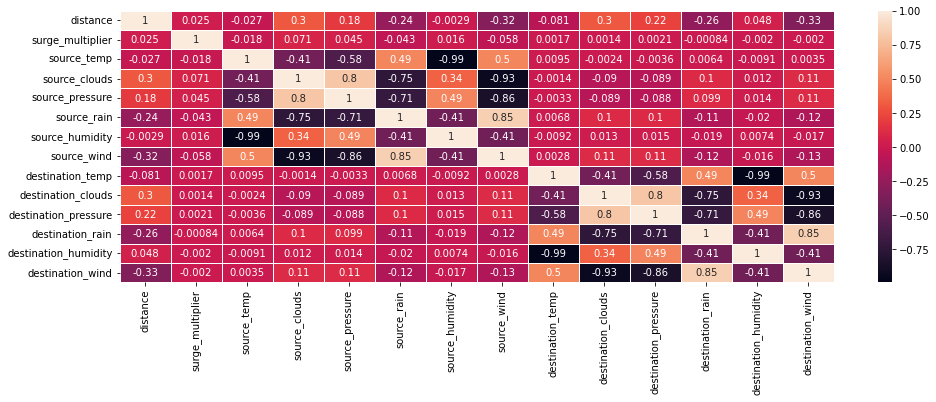

In [184]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(data.corr(), annot=True, linewidths=1)

In [185]:
dataX = data.drop(['RideCategory'],axis=1)
cor_matrix = dataX.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
print(to_drop)
data = data.drop(to_drop, axis=1)

['source_humidity', 'source_wind', 'destination_humidity', 'destination_wind']


### remove outliers

In [186]:
from scipy import stats
def cap_data(df):
    for col in df.select_dtypes(include=['float64','int64']).columns:
            df= df[(np.abs(stats.zscore(df[col])) < 3)]
    return df


### Encdoing Data

In [187]:
print(data['surge_multiplier'].unique())
#data=cap_data(data)
#dataTrain,dataTest = split_stratified_into_train_val_test(data,stratify_colname='RideCategory', frac_train=0.60, frac_test=0.20)

[1.   1.25 1.5  2.   1.75 2.5  3.  ]


In [188]:
#dataTrain = cap_data(dataTrain)
#dataTest = cap_data(dataTest)
#data = cap_data(data)

In [189]:
#print(dataTrain['surge_multiplier'].unique())


Using mean Encdoing to encode data since it has great balance between efficency and model complexity

In [190]:
def mean_encoding(data):
    for col in data.select_dtypes(include='O').columns:
        encoder = TargetEncoder()
        data[col] = encoder.fit_transform(data[col],data['RideCategory'])
    return data


In [191]:
def label_encoding(data):
    print(data.select_dtypes(include='O').columns)
    for col in data.select_dtypes(include='O').columns:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])
        pickle.dump(encoder, open(f'{col}.pkl', 'wb'))
    return data

In [192]:
#dataTrain['surge_multiplier'].unique()
data['surge_multiplier'].unique()


array([1.  , 1.25, 1.5 , 2.  , 1.75, 2.5 , 3.  ])

In [193]:
#dataTrain = label_encoding(dataTrain)
#dataTest = label_encoding(dataTest)
data = label_encoding(data)

Index(['cab_type', 'destination', 'source', 'name', 'RideCategory',
       'time_of_day'],
      dtype='object')


In [194]:
data['surge_multiplier'].unique()


array([1.  , 1.25, 1.5 , 2.  , 1.75, 2.5 , 3.  ])

In [195]:
data.RideCategory.unique()

array([3, 2, 0, 1, 4])

Index(['distance', 'surge_multiplier', 'name', 'RideCategory'], dtype='object')
Index(['distance', 'surge_multiplier', 'name'], dtype='object')


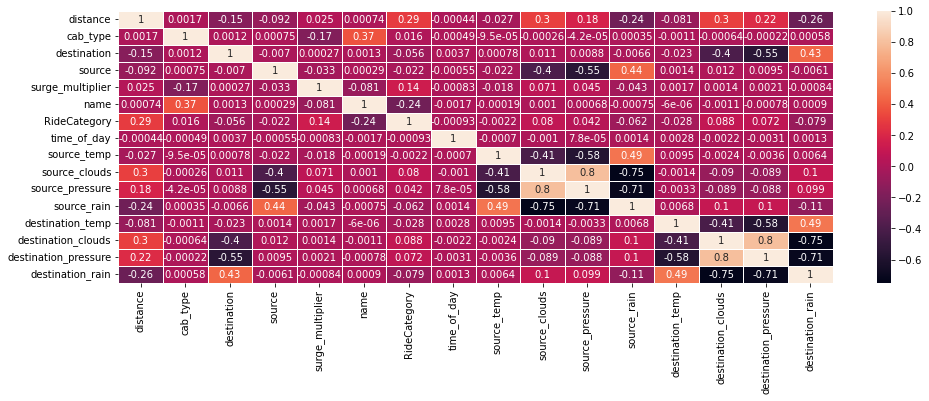

In [196]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(corr, annot=True, linewidths=1)
top_feature = corr.index[abs(corr['RideCategory']) > 0.1]
top_feature.drop('RideCategory')
print(top_feature)
X = data[top_feature]
X.drop(['RideCategory'], axis=1, inplace=True)
print(X.columns)
y = data['RideCategory']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.20, shuffle=True, random_state=10)
#X_train = dataTrain.drop(['RideCategory'],axis=1)
#X_test = dataTest.drop(['RideCategory'],axis=1)
#y_train = dataTrain.RideCategory
#y_test = dataTest.RideCategory

In [198]:
scaler = MinMaxScaler()
scaler.fit(X_train)
pickle.dump(scaler, open('scaler.pkl', 'wb'))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [199]:
def decision_tree_model(X_test, X_train, y_test, y_train):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    pickle.dump(clf, open('decision_tree.pkl', 'wb'))
    pred = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print("Decision Tree Train Accuracy:",
          metrics.accuracy_score(y_train, train_pred)*100.0)
    #print test accuracy
    print("Decision Tree Test Accuracy:", metrics.accuracy_score(y_test, pred)*100.0)    

In [200]:
def random_forest_model(X_test, X_train, y_test, y_train, maxDepth=5, n_estimators=100,random_state=0):
    clrf = RandomForestClassifier(
        max_depth=maxDepth, random_state=random_state, n_estimators=n_estimators)
    clrf.fit(X_train, y_train)
    pickle.dump(clrf, open('random_forest.pkl', 'wb'))
    pred2 = clrf.predict(X_test)
    train_pred = clrf.predict(X_train)
    #print train accuracy
    print('Random Forest Train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    #print test accuracy
    print('Random Forest Test Accuracy', metrics.accuracy_score(y_test, pred2) * 100.0)


In [201]:
#import svc
from sklearn import svm
#import sklearn.linear_model.SGDClassifier
from sklearn.linear_model import SGDClassifier
def svm_model(X_test, X_train, y_test, y_train):
    #feature reduction
    linear = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=100, random_state=42)
    linear.fit(X_train, y_train)
    pickle.dump(linear, open('svm.pkl', 'wb'))
    pred3 = linear.predict(X_test)
    train_pred = linear.predict(X_train)
    #print train accuracy
    print('svm Train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('svm Test Accuracy', metrics.accuracy_score(y_test, pred3) * 100.0)


In [202]:
#logistic regression
from sklearn.linear_model import LogisticRegression
def logistic_regression_model(X_test, X_train, y_test, y_train):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('logistic_regression.pkl', 'wb'))
    pred4 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print('logistic_regression Train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('logistic_regression Test Accuracy',
          metrics.accuracy_score(y_test, pred4) * 100.0)


In [203]:
#naiive bayes
def naive_bayes_model(X_test, X_train, y_test, y_train):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('naive_bayes.pkl', 'wb'))
    pred5 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print('naive_bayes Train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('naive_bayes Test Accuracy', metrics.accuracy_score(y_test, pred5) * 100.0)

In [204]:
from sklearn.svm import SVC
def ada_boost_model(X_test, X_train, y_test, y_train, n_estimators=100, learning_rate=1.0, random_state=0):
    svc = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, max_iter=100, random_state=42)
    clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                             random_state=random_state, base_estimator=svc, algorithm='SAMME')
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('ada_boost.pkl', 'wb'))
    pred6 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print('ada_boost train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print(f'ada boost test Accuracy', metrics.accuracy_score(y_test, pred6) * 100.0)

In [205]:
#KNN
def knn_model(X_test, X_train, y_test, y_train):
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('knn.pkl', 'wb'))
    pred7 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print('KNN train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('KNN test Accuracy', metrics.accuracy_score(y_test, pred7) * 100.0)


In [206]:
#LGBMClassifier
from lightgbm import LGBMClassifier
def light_gbm_model(X_test, X_train, y_test, y_train):
    clf = LGBMClassifier(objective='multiclass', num_class=4,
                         learning_rate=0.1, n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('light_gbm.pkl', 'wb'))
    pred8 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #print train accuracy
    print('light_gbm train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('light_gbm test Accuracy', metrics.accuracy_score(y_test, pred8) * 100.0)

In [207]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting_model(X_test, X_train, y_test, y_train):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                     max_depth=1, random_state=0)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('gradient_boosting.pkl', 'wb'))
    pred9 = clf.predict(X_test)
    train_pred = clf.predict(X_train)
    #plot feature importance
    #print train accuracy
    print('gradient_boosting train Accuracy', metrics.accuracy_score(y_train, train_pred) * 100.0)
    print('gradient_boosting test Accuracy', metrics.accuracy_score(y_test, pred9) * 100.0)
    

In [208]:
gradient_boosting_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'gradient_boosting.pkl')

gradient_boosting train Accuracy 87.77605937361915
gradient_boosting test Accuracy 87.88009955632508
gradient_boosting.pkl acc 25.0
[2 0 0]
1    0
2    0
3    3
Name: RideCategory, dtype: int64


In [209]:
light_gbm_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'light_gbm.pkl')


light_gbm train Accuracy 89.10777249731719
light_gbm test Accuracy 88.99199220863542
light_gbm.pkl acc 25.0
[2 0 0]
1    0
2    0
3    3
Name: RideCategory, dtype: int64


In [210]:
logistic_regression_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'logistic_regression.pkl')


logistic_regression Train Accuracy 49.157731466034214
logistic_regression Test Accuracy 49.51033437939617
logistic_regression.pkl acc 50.0
[0 0 0]
1    0
2    0
3    3
Name: RideCategory, dtype: int64


In [211]:
decision_tree_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'decision_tree.pkl')


decision_tree.pkl acc 25.0
[2 0 0]
1    0
2    0
3    3
Name: RideCategory, dtype: int64


In [212]:
random_forest_model(X_test, X_train, y_test, y_train, maxDepth=12, n_estimators=100,random_state=42)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'random_forest.pkl')


Random Forest Train Accuracy 89.1411385955578
Random Forest Test Accuracy 88.91624283086246
random_forest.pkl acc 25.0
[2 0 0]
1    0
2    0
3    3
Name: RideCategory, dtype: int64


In [213]:
ada_boost_model(X_test, X_train, y_test, y_train, n_estimators=100,
                learning_rate=0.1)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'ada_boost.pkl')


In [ ]:
def label_encoding(data):
    print(data.select_dtypes(include='O').columns)
    for col in data.select_dtypes(include='O').columns:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])
        pickle.dump(encoder, open(f'{col}.pkl', 'wb'))
    return data

In [ ]:
naive_bayes_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'naive_bayes.pkl')


naive_bayes Train Accuracy 57.37190746223717
naive_bayes Test Accuracy 57.283369373808156
naive_bayes.pkl acc 57.21354569352095
[0 0 3 1 3 3 0 1 2]
1    0
2    0
3    3
4    1
5    3
6    3
7    1
8    2
9    2
Name: RideCategory, dtype: int64


In [ ]:
knn_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'knn.pkl')

KNN train Accuracy 87.28426940149728
KNN test Accuracy 86.95608536574238
knn.pkl acc 82.88232565331684
[0 0 3 1 3 3 1 1 2]
1    0
2    0
3    3
4    1
5    3
6    3
7    1
8    2
9    2
Name: RideCategory, dtype: int64


In [ ]:
svm_model(X_test, X_train, y_test, y_train)
test_sample(pd.read_csv('taxi-test-samples.csv'), 'svm.pkl')

svm Train Accuracy 46.25063299223986
svm Test Accuracy 46.41465706803894
svm.pkl acc 45.2914798206278
[0 0 0 1 2 0 0 1 0]
1    0
2    0
3    3
4    1
5    3
6    3
7    1
8    2
9    2
Name: RideCategory, dtype: int64
